In [1]:
import os
import csv
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim 
from torchvision import transforms, datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from datetime import datetime
import torchvision.models as models
import random
import numpy as np


In [2]:
# 画像のサイズ
IMG_SIZE = 224

# データのディレクトリのパス
FLOWER_DIR = '../input/flowers'

batch_size = 128


In [3]:
# GPUが利用可能かどうかを確認し、利用可能ならGPUを使用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


# データセットの作成

In [4]:
transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), # 画像サイズをリサイズ,
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# データセットを作成
dataset = datasets.ImageFolder(FLOWER_DIR, transform=transforms)


In [5]:
# 学習データに使用する割合
n_train_ratio = 0.9

# 割合から個数を出す
n_train = int(len(dataset) * n_train_ratio)
n_val   = int(len(dataset) - n_train)


In [6]:
# 学習データと検証データに分割
train, val = random_split(dataset, [n_train, n_val])


In [7]:
# 最初の数個のサンプルを表示
for i in range(5):
    print(train[i])


(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -

In [8]:
# Data Loader
train_loader = DataLoader(train, batch_size, shuffle=True, drop_last=True, num_workers=2)
val_loader = DataLoader(val, batch_size, num_workers=2)


In [9]:
# ResNet-18モデルの定義
class CustomResNet18(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet18, self).__init__()
        self.resnet = models.resnet18(weights=None)  # 事前学習済みのResNet-18モデルをロード
        # 最終の全結合層を入れ替えて、出力クラスの数に合わせる
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)


In [10]:
# 2. モデルの構築
model = CustomResNet18(num_classes=5).to(device)


In [11]:
# 3. 訓練と検証
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)



In [12]:
def train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # 訓練フェーズ
        model.train()
        train_loss, train_correct = 0, 0
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}, Training...'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()

        # 検証フェーズ
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs}, Validation...'):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()

        # 損失と精度の計算
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accuracies.append(train_correct / len(train_loader.dataset))
        val_accuracies.append(val_correct / len(val_loader.dataset))

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train Acc: {train_accuracies[-1]}, Val Acc: {val_accuracies[-1]}')

    return train_losses, val_losses, train_accuracies, val_accuracies


In [13]:
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer)


Epoch 1/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 1/50, Train Loss: 1.3179802397886913, Val Loss: 1.3547031581401825, Train Acc: 0.4797940797940798, Val Acc: 0.5115740740740741


Epoch 2/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Epoch 2/50, Train Loss: 0.9613424976666768, Val Loss: 1.2408596575260162, Train Acc: 0.6175032175032175, Val Acc: 0.5486111111111112


Epoch 3/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 3/50, Train Loss: 0.8595596094926198, Val Loss: 1.1408487856388092, Train Acc: 0.6646074646074646, Val Acc: 0.5949074074074074


Epoch 4/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


Epoch 4/50, Train Loss: 0.8215129991372426, Val Loss: 1.5791487097740173, Train Acc: 0.6815958815958816, Val Acc: 0.5300925925925926


Epoch 5/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Epoch 5/50, Train Loss: 0.7525869925816854, Val Loss: 1.1281893849372864, Train Acc: 0.7063063063063063, Val Acc: 0.6574074074074074


Epoch 6/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 6/50, Train Loss: 0.7459679981072743, Val Loss: 1.0299582183361053, Train Acc: 0.7088803088803088, Val Acc: 0.6828703703703703


Epoch 7/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Epoch 7/50, Train Loss: 0.7076205690701802, Val Loss: 0.9344950318336487, Train Acc: 0.7243243243243244, Val Acc: 0.6805555555555556


Epoch 8/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 8/50, Train Loss: 0.6929505507151286, Val Loss: 1.031556397676468, Train Acc: 0.72998712998713, Val Acc: 0.6412037037037037


Epoch 9/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Epoch 9/50, Train Loss: 0.6602917532126109, Val Loss: 0.9573182016611099, Train Acc: 0.7438867438867439, Val Acc: 0.7129629629629629


Epoch 10/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 10/50, Train Loss: 0.6045541812976202, Val Loss: 1.1518306136131287, Train Acc: 0.7711711711711712, Val Acc: 0.6180555555555556


Epoch 11/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 11/50, Train Loss: 0.6346928377946218, Val Loss: 0.9748772084712982, Train Acc: 0.7621621621621621, Val Acc: 0.6620370370370371


Epoch 12/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Epoch 12/50, Train Loss: 0.5583589265743891, Val Loss: 1.1508810222148895, Train Acc: 0.7861003861003861, Val Acc: 0.6064814814814815


Epoch 13/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 13/50, Train Loss: 0.5480736315250396, Val Loss: 0.8138009011745453, Train Acc: 0.7861003861003861, Val Acc: 0.7199074074074074


Epoch 14/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 14/50, Train Loss: 0.5007891486088435, Val Loss: 1.048251062631607, Train Acc: 0.8002574002574002, Val Acc: 0.6435185185185185


Epoch 15/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 15/50, Train Loss: 0.5258491297562917, Val Loss: 0.7845253348350525, Train Acc: 0.8007722007722008, Val Acc: 0.7314814814814815


Epoch 16/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Epoch 16/50, Train Loss: 0.48461850384871163, Val Loss: 0.9568817168474197, Train Acc: 0.811068211068211, Val Acc: 0.7106481481481481


Epoch 17/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Epoch 17/50, Train Loss: 0.4679885983467102, Val Loss: 0.770825058221817, Train Acc: 0.8218790218790218, Val Acc: 0.7337962962962963


Epoch 18/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Epoch 18/50, Train Loss: 0.47573486268520354, Val Loss: 0.8524492979049683, Train Acc: 0.8144144144144144, Val Acc: 0.7314814814814815


Epoch 19/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 19/50, Train Loss: 0.431447238723437, Val Loss: 1.474283367395401, Train Acc: 0.8303732303732304, Val Acc: 0.6319444444444444


Epoch 20/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Epoch 20/50, Train Loss: 0.4318691730499268, Val Loss: 1.2281356900930405, Train Acc: 0.827027027027027, Val Acc: 0.7037037037037037


Epoch 21/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Epoch 21/50, Train Loss: 0.4068672368923823, Val Loss: 1.048715427517891, Train Acc: 0.8380952380952381, Val Acc: 0.6828703703703703


Epoch 22/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 22/50, Train Loss: 0.39222458402315774, Val Loss: 0.7075748294591904, Train Acc: 0.8447876447876448, Val Acc: 0.7800925925925926


Epoch 23/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Epoch 23/50, Train Loss: 0.36473364382982254, Val Loss: 0.8045051097869873, Train Acc: 0.8558558558558559, Val Acc: 0.7314814814814815


Epoch 24/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


Epoch 24/50, Train Loss: 0.35130198746919633, Val Loss: 0.7493946850299835, Train Acc: 0.8633204633204633, Val Acc: 0.7638888888888888


Epoch 25/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Epoch 25/50, Train Loss: 0.3460923949877421, Val Loss: 0.8796108663082123, Train Acc: 0.8676962676962677, Val Acc: 0.7523148148148148


Epoch 26/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 26/50, Train Loss: 0.3289577345053355, Val Loss: 0.7966383099555969, Train Acc: 0.8679536679536679, Val Acc: 0.75


Epoch 27/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Epoch 27/50, Train Loss: 0.31746855477492014, Val Loss: 0.7607725560665131, Train Acc: 0.8769626769626769, Val Acc: 0.7754629629629629


Epoch 28/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Epoch 28/50, Train Loss: 0.2762196327249209, Val Loss: 0.8169787675142288, Train Acc: 0.8924066924066925, Val Acc: 0.7430555555555556


Epoch 29/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 29/50, Train Loss: 0.3123663564523061, Val Loss: 0.9694325476884842, Train Acc: 0.8738738738738738, Val Acc: 0.7337962962962963


Epoch 30/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Epoch 30/50, Train Loss: 0.2840635235110919, Val Loss: 0.8425601124763489, Train Acc: 0.8867438867438867, Val Acc: 0.7638888888888888


Epoch 31/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 31/50, Train Loss: 0.27334936112165453, Val Loss: 0.7206301391124725, Train Acc: 0.8913770913770914, Val Acc: 0.7800925925925926


Epoch 32/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 32/50, Train Loss: 0.2632714961965879, Val Loss: 0.9008366763591766, Train Acc: 0.8936936936936937, Val Acc: 0.7824074074074074


Epoch 33/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 33/50, Train Loss: 0.2451750506957372, Val Loss: 0.7744864821434021, Train Acc: 0.8965250965250965, Val Acc: 0.7662037037037037


Epoch 34/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 34/50, Train Loss: 0.22429083039363226, Val Loss: 0.8022056818008423, Train Acc: 0.9096525096525097, Val Acc: 0.7800925925925926


Epoch 35/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 35/50, Train Loss: 0.22745966513951618, Val Loss: 0.9000313431024551, Train Acc: 0.905019305019305, Val Acc: 0.7754629629629629


Epoch 36/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 36/50, Train Loss: 0.22699809670448304, Val Loss: 0.8513403683900833, Train Acc: 0.9065637065637066, Val Acc: 0.7662037037037037


Epoch 37/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Epoch 37/50, Train Loss: 0.2302964503566424, Val Loss: 0.988664522767067, Train Acc: 0.9003861003861003, Val Acc: 0.7476851851851852


Epoch 38/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 38/50, Train Loss: 0.19172355011105538, Val Loss: 0.8638302832841873, Train Acc: 0.9178893178893179, Val Acc: 0.7615740740740741


Epoch 39/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 39/50, Train Loss: 0.15319249878327051, Val Loss: 0.7599324434995651, Train Acc: 0.9374517374517375, Val Acc: 0.8240740740740741


Epoch 40/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 40/50, Train Loss: 0.12894806787371635, Val Loss: 0.7813298851251602, Train Acc: 0.9446589446589446, Val Acc: 0.7824074074074074


Epoch 41/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 41/50, Train Loss: 0.19410539368788401, Val Loss: 0.8760332763195038, Train Acc: 0.9184041184041184, Val Acc: 0.7939814814814815


Epoch 42/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 42/50, Train Loss: 0.17127712219953536, Val Loss: 0.8144501596689224, Train Acc: 0.9307593307593307, Val Acc: 0.7986111111111112


Epoch 43/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Epoch 43/50, Train Loss: 0.14414770230650903, Val Loss: 0.7536619007587433, Train Acc: 0.9366795366795366, Val Acc: 0.8055555555555556


Epoch 44/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 44/50, Train Loss: 0.14634810077647367, Val Loss: 0.7979601174592972, Train Acc: 0.9382239382239382, Val Acc: 0.7962962962962963


Epoch 45/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 45/50, Train Loss: 0.12837291844189166, Val Loss: 0.9882404804229736, Train Acc: 0.9425997425997426, Val Acc: 0.7175925925925926


Epoch 46/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 46/50, Train Loss: 0.1251999703546365, Val Loss: 0.9766004383563995, Train Acc: 0.9467181467181467, Val Acc: 0.7962962962962963


Epoch 47/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Epoch 47/50, Train Loss: 0.1266606508443753, Val Loss: 0.9551707357168198, Train Acc: 0.9438867438867439, Val Acc: 0.7870370370370371


Epoch 48/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Epoch 48/50, Train Loss: 0.14012522337337335, Val Loss: 0.8081288933753967, Train Acc: 0.9402831402831403, Val Acc: 0.8032407407407407


Epoch 49/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 49/50, Train Loss: 0.09989473683138689, Val Loss: 0.7352132201194763, Train Acc: 0.9531531531531532, Val Acc: 0.7962962962962963


Epoch 50/50, Validation...: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]

Epoch 50/50, Train Loss: 0.09990963252882162, Val Loss: 1.1768235862255096, Train Acc: 0.9541827541827542, Val Acc: 0.7824074074074074


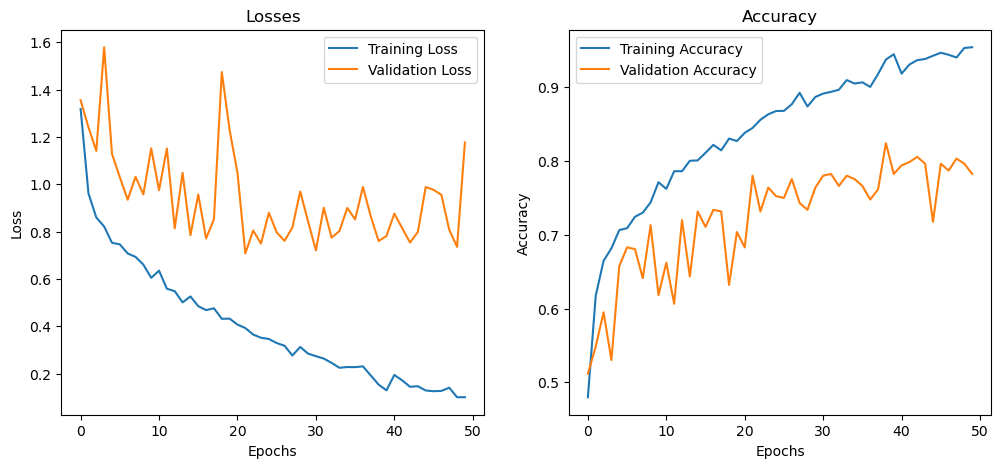

In [14]:
# グラフを保存するディレクトリを作成
output_dir = '../results'
os.makedirs(output_dir, exist_ok=True)

# タイムスタンプを生成
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')


# LossとAccuracyのデータをCSVファイルに保存
csv_filename = os.path.join(output_dir, f'ResNet18_{timestamp}.csv')
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy'])
    
    for epoch in range(len(train_losses)):
        writer.writerow([epoch+1, train_losses[epoch], val_losses[epoch], train_accuracies[epoch], val_accuracies[epoch]])


# Lossのグラフを保存
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title(f'Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracyのグラフを保存
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title(f'Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 画像を保存
plt.savefig(os.path.join(output_dir, f'ResNet18_{timestamp}.png'))

# 画像を表示
plt.show()
